In [1]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# --- 1. Konfiguration ---
INPUT_NPZ_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/top_1000_transcripts.npz'
window_size = 5
lag_offset = 15
USE_HYBRID_MIXING = True # NEU: Schalter für die Normalisierungsmethode
N_ITER = 20

# --- 2. Hilfsfunktionen ---
def create_lagging_windows(read_counts, window_size, lag_offset):
    padded_counts = np.pad(read_counts, (lag_offset, 0), 'constant', constant_values=0.01)
    num_windows = len(read_counts)
    shape = (num_windows, window_size)
    strides = (padded_counts.strides[0], padded_counts.strides[0])
    windows = np.lib.stride_tricks.as_strided(padded_counts, shape=shape, strides=strides)
    return windows

def load_processed_data(file_path):
    print(f"Lade verarbeitete Daten von {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Fehler: Datendatei nicht gefunden: {file_path}")
        return None
    try:
        data_loader = np.load(file_path, allow_pickle=True)
        transcript_data = {key: data_loader[key] for key in data_loader.files}
        print(f"✅ {len(transcript_data)} Transkripte erfolgreich geladen.")
        return transcript_data
    except Exception as e:
        print(f"❌ Fehler beim Laden der .npz-Datei: {e}")
        return None

# --- 3. Daten laden und für HMM vorbereiten ---
transcript_data = load_processed_data(INPUT_NPZ_FILE)
if not transcript_data:
    exit()

print(f"Bereite Trainingsdaten für das HMM vor ({window_size}-nt Lagging Window)...")
all_X_windows = []
lengths_of_windows = []

for tid, read_counts in tqdm(transcript_data.items(), desc="Verarbeite Transkripte"):
    if len(read_counts) == 0:
        continue
    read_counts = read_counts + np.random.uniform(0.001, 0.01, size=read_counts.shape)
    X_single_transcript = create_lagging_windows(read_counts, window_size, lag_offset)
    all_X_windows.append(X_single_transcript.astype(np.int32))
    lengths_of_windows.append(len(X_single_transcript))

X_train = np.concatenate(all_X_windows)
print(f"✅ Trainings-Set erstellt mit {X_train.shape[0]} Fenstern der Größe {X_train.shape[1]} aus {len(lengths_of_windows)} Transkripten.")

Lade verarbeitete Daten von /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/top_1000_transcripts.npz...
✅ 1000 Transkripte erfolgreich geladen.
Bereite Trainingsdaten für das HMM vor (5-nt Lagging Window)...


Verarbeite Transkripte: 100%|██████████| 1000/1000 [00:00<00:00, 11257.16it/s]

✅ Trainings-Set erstellt mit 3977752 Fenstern der Größe 5 aus 1000 Transkripten.


In [11]:
X_single_transcript

array([[0.01      , 0.01      , 0.01      , 0.01      , 0.01      ],
       [0.01      , 0.01      , 0.01      , 0.01      , 0.01      ],
       [0.01      , 0.01      , 0.01      , 0.01      , 0.01      ],
       ...,
       [0.00173243, 0.00588726, 0.00279246, 0.00812829, 0.00415298],
       [0.00588726, 0.00279246, 0.00812829, 0.00415298, 0.00571619],
       [0.00279246, 0.00812829, 0.00415298, 0.00571619, 0.00502319]],
      shape=(2164, 5))

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Visualisierung der Initial-Parameter (gruppiert)...


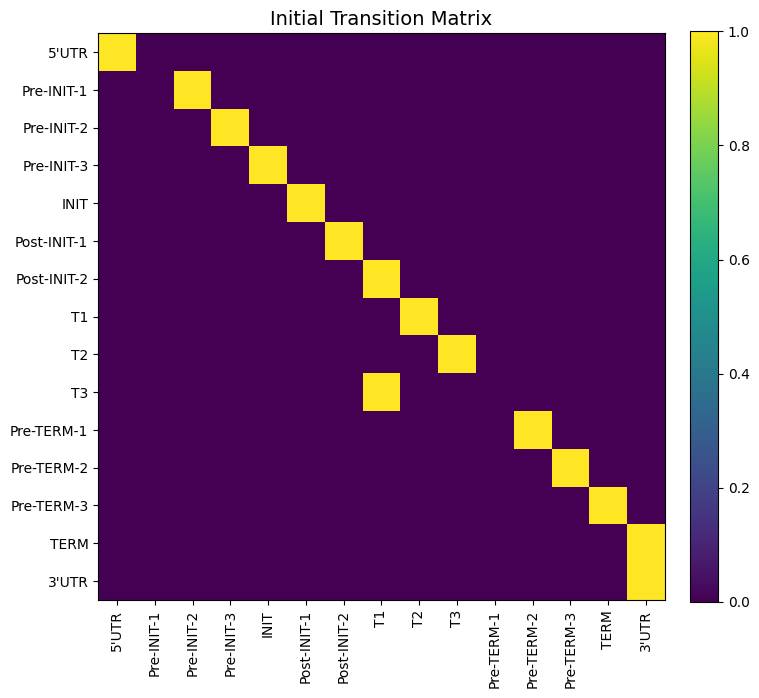

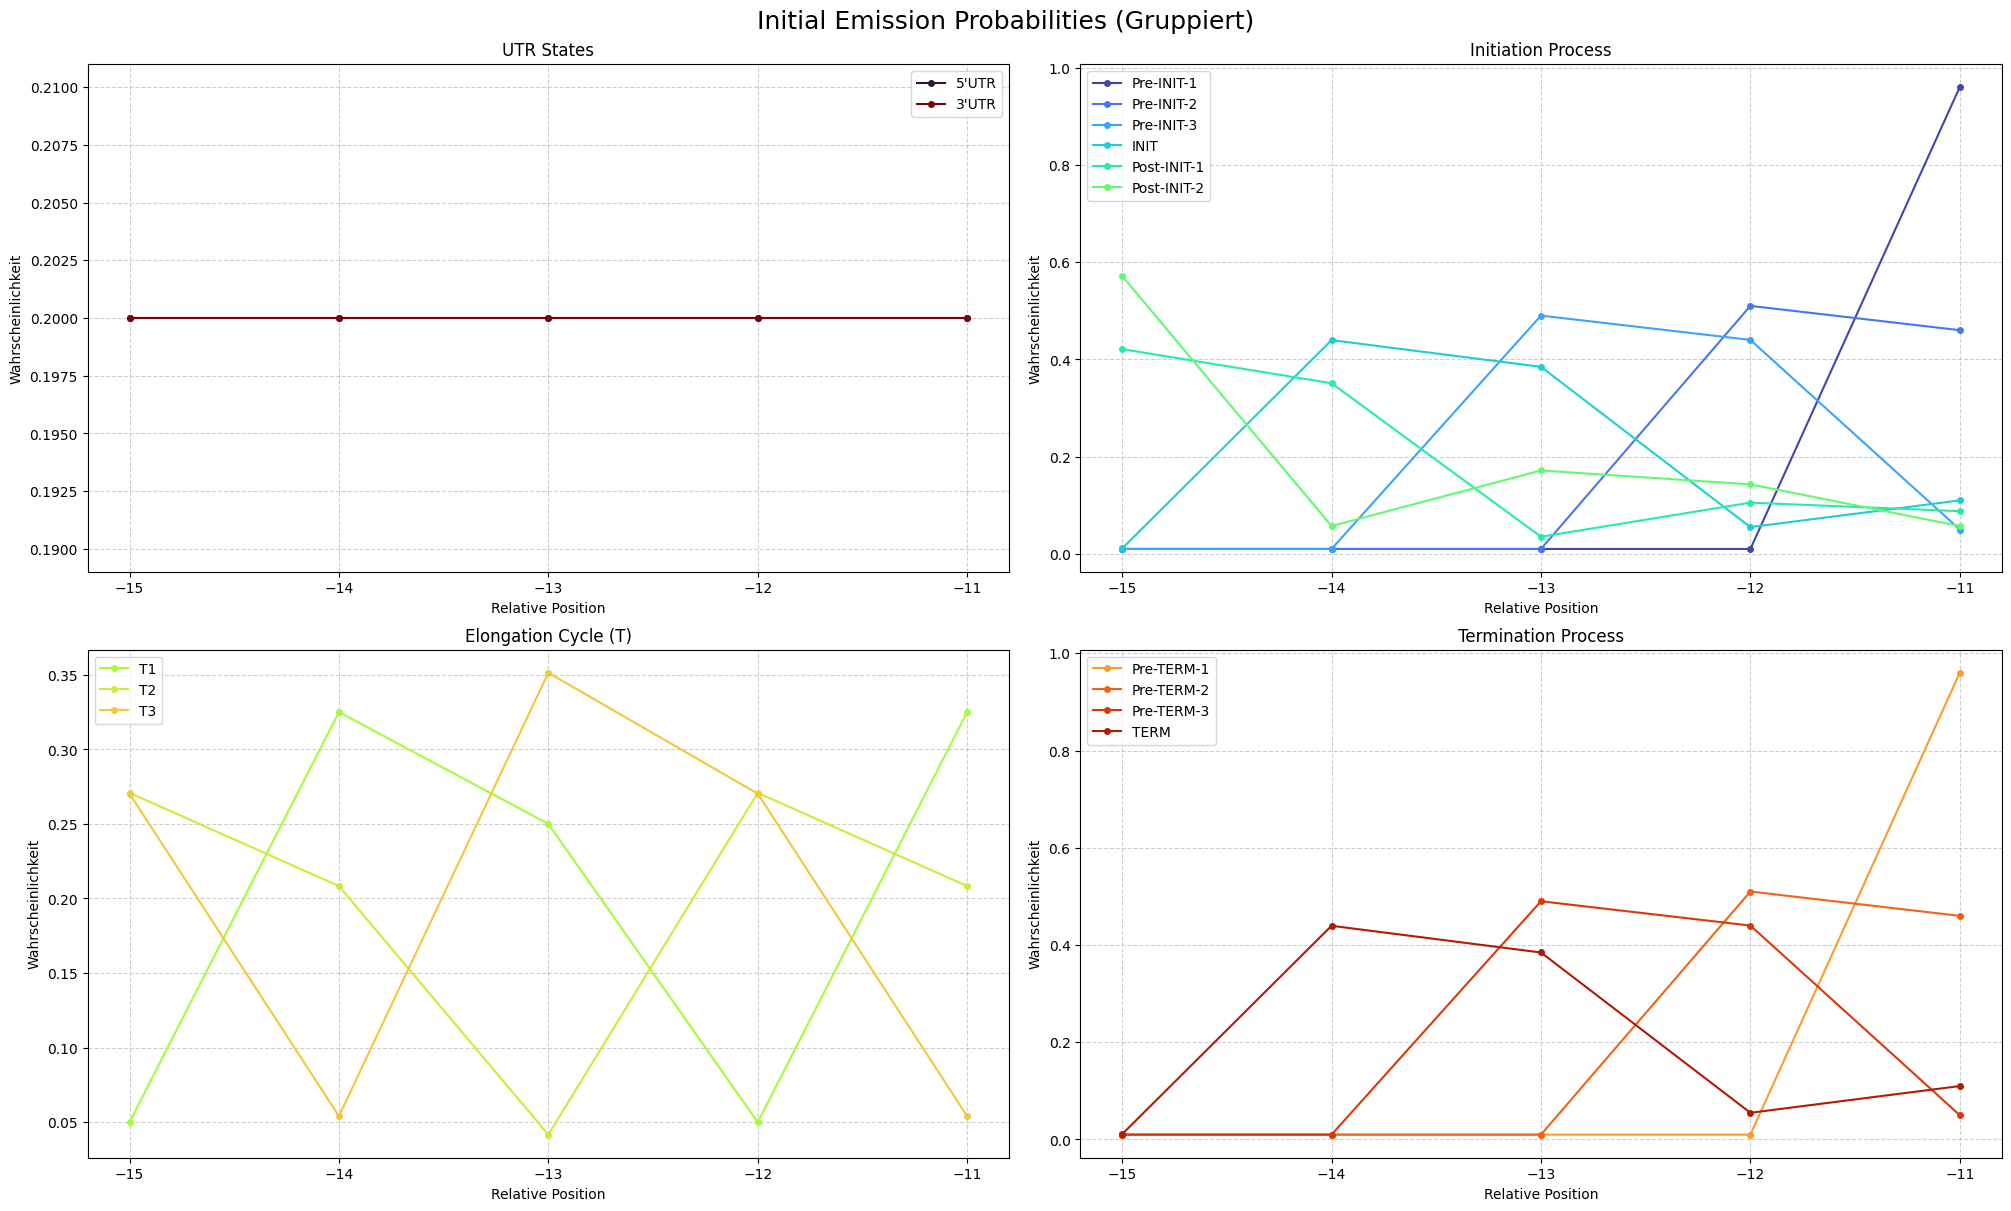

In [ ]:
# --- 1. Modelldefinitionen ---
state_map = {
    "5'UTR": 0, 'Pre-INIT-1': 1, 'Pre-INIT-2': 2, 'Pre-INIT-3': 3, 'INIT': 4,
    'Post-INIT-1': 5, 'Post-INIT-2': 6, 'T1': 7, 'T2': 8, 'T3': 9,
    'Pre-TERM-1': 10, 'Pre-TERM-2': 11, 'Pre-TERM-3': 12, 'TERM': 13, "3'UTR": 14
}
n_components = len(state_map)
n_features = window_size
state_labels = list(state_map.keys())
state_colors = plt.cm.turbo(np.linspace(0, 1, n_components))
fixed_emission_states = []
USE_HYBRID_MIXING = False

# --- 2. Emissions-Signaturen definieren ---
emission_blueprints = {
    "5'UTR":        [1, 1, 1, 1, 1],
    'Pre-INIT-1':   [1, 1, 1, 1, 96], 'Pre-INIT-2':   [1, 1, 1, 51, 46],
    'Pre-INIT-3':   [1, 1, 49, 44, 5], 'INIT':         [1, 40, 35, 5, 10],
    'Post-INIT-1':  [60, 50, 5, 15, 12.5], 'Post-INIT-2':  [50, 5, 15, 12.5, 5],
    'T1':           [5, 32.5, 25, 5, 32.5], 'T2':           [32.5, 25, 5, 32.5, 25],
    'T3':           [25, 5, 32.5, 25, 5],
    'Pre-TERM-1':   [1, 1, 1, 1, 96], 'Pre-TERM-2':   [1, 1, 1, 51, 46],
    'Pre-TERM-3':   [1, 1, 49, 44, 5], 'TERM':         [1, 40, 35, 5, 10],
    "3'UTR":        [1, 1, 1, 1, 1]
}

# --- 3. Normalisierungsfunktion ---
def normalize_emissions(unnormalized_emissions, use_hybrid_mixing=False):
    row_sums = unnormalized_emissions.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    shape_component = unnormalized_emissions / row_sums
    if not use_hybrid_mixing: return shape_component
    
    mean_magnitudes = unnormalized_emissions.mean(axis=1)
    learnable_magnitudes = np.delete(mean_magnitudes, fixed_emission_states)
    max_mean_magnitude = learnable_magnitudes.max() if len(learnable_magnitudes) > 0 else 1.0
    if max_mean_magnitude == 0: max_mean_magnitude = 1.0
    
    background_component = np.full_like(unnormalized_emissions, 1.0 / n_features)
    mixing_weights = np.clip((mean_magnitudes / max_mean_magnitude), 0, 1)[:, np.newaxis]
    hybrid_emissions = mixing_weights * shape_component + (1 - mixing_weights) * background_component
    final_sums = hybrid_emissions.sum(axis=1, keepdims=True)
    return hybrid_emissions / np.where(final_sums == 0, 1, final_sums)

# --- 4. HMM-Instanz und Parameter-Initialisierung ---
model = hmm.MultinomialHMM(n_components=n_components,
                           n_iter=N_ITER,
                           tol=1e-4,
                           verbose=True,
                           params='te', 
                           init_params='',
                           random_state=42)
model.startprob_ = np.array([1.0] + [0.0] * (n_components - 1))
transmat = np.zeros((n_components, n_components))
for i in range(n_components - 1):
    if i in [state_map["5'UTR"], state_map["T3"], state_map["TERM"], state_map["3'UTR"]]: continue
    transmat[i, i + 1] = 1.0
transmat[state_map["5'UTR"], state_map["5'UTR"]] = 0.9999
transmat[state_map["5'UTR"], state_map["Pre-INIT-1"]] = 0.0001
p_elong_cycle = 0.999
transmat[state_map["T3"], state_map["T1"]] = p_elong_cycle
transmat[state_map["T3"], state_map["Pre-TERM-1"]] = 1.0 - p_elong_cycle
transmat[state_map["TERM"], state_map["3'UTR"]] = 1.0
transmat[state_map["3'UTR"], state_map["3'UTR"]] = 1.0
model.transmat_ = transmat

unnormalized_emissions = np.array([emission_blueprints[label] for label in state_labels])
initial_emissionprob = normalize_emissions(unnormalized_emissions, use_hybrid_mixing=USE_HYBRID_MIXING)
model.emissionprob_ = initial_emissionprob.copy()
initial_emissionprob_snapshot = initial_emissionprob.copy()

# --- 5. Visualisierung der Initial-Parameter (JETZT GRUPPIERT) ---
print("Visualisierung der Initial-Parameter (gruppiert)...")

# Definition der Gruppen für die Plots
plot_groups = {
    "UTR States": ["5'UTR", "3'UTR"],
    "Initiation Process": ['Pre-INIT-1', 'Pre-INIT-2', 'Pre-INIT-3', 'INIT', 'Post-INIT-1', 'Post-INIT-2'],
    "Elongation Cycle (T)": ['T1', 'T2', 'T3'],
    "Termination Process": ['Pre-TERM-1', 'Pre-TERM-2', 'Pre-TERM-3', 'TERM']
}

# Erstelle eine Abbildung für die Übergangsmatrix und eine für die Emissionen
fig_transmat = plt.figure(figsize=(8, 8))
ax_transmat = fig_transmat.add_subplot(111)
im = ax_transmat.imshow(model.transmat_, cmap="viridis")
ax_transmat.set_title("Initial Transition Matrix", fontsize=14)
ax_transmat.set_xticks(np.arange(n_components))
ax_transmat.set_yticks(np.arange(n_components))
ax_transmat.set_xticklabels(state_labels, rotation=90)
ax_transmat.set_yticklabels(state_labels)
plt.colorbar(im, ax=ax_transmat, fraction=0.046, pad=0.04)
plt.show()

# Erstelle eine 2x2-Abbildung für die gruppierten Emissions-Plots
fig_emissions, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)
fig_emissions.suptitle("Initial Emission Probabilities (Gruppiert)", fontsize=18)
x_labels_rel = np.arange(n_features) - lag_offset

for ax, (group_name, members) in zip(axs.flat, plot_groups.items()):
    ax.set_title(group_name)
    for state_name in members:
        state_idx = state_map[state_name]
        ax.plot(x_labels_rel, model.emissionprob_[state_idx], 'o-', color=state_colors[state_idx], label=state_name, markersize=4)
    ax.set_xlabel("Relative Position")
    ax.set_ylabel("Wahrscheinlichkeit")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xticks(x_labels_rel)
    ax.legend()

plt.show()

In [3]:
print("Starte Training des MultinomialHMM...")
print(f"Trainingsparameter: params='{model.params}', init_params='{model.init_params}'")
print(f"Anzahl Iterationen: {model.n_iter}, Toleranz: {model.tol}")

model.fit(X_train, lengths=lengths_of_windows)

print("✅ Training abgeschlossen.")

print(f"Setze Emissionen für fixierte Zustände zurück: {[state_labels[i] for i in fixed_emission_states]}")
for state_idx in fixed_emission_states:
    model.emissionprob_[state_idx] = initial_emissionprob_snapshot[state_idx]
print("Reset abgeschlossen.")

Starte Training des MultinomialHMM...
Trainingsparameter: params='e', init_params=''
Anzahl Iterationen: 20, Toleranz: 0.0001


         1 -3880253.78744304             +nan
         2 -3678014.51681964 +202239.27062340
         3 -3653737.10173923  +24277.41508041
         4 -3649308.12110853   +4428.98063070
         5 -3647900.78889215   +1407.33221638
         6 -3647293.72729693    +607.06159522
         7 -3647039.65268403    +254.07461290
         8 -3646798.19637239    +241.45631164
         9 -3646531.17270239    +267.02367000
        10 -3646253.02740277    +278.14529963
        11 -3646077.11751440    +175.90988837
        12 -3646052.22611809     +24.89139631
        13 -3646051.08451401      +1.14160408
        14 -3646051.05816739      +0.02634662
        15 -3646051.05723369      +0.00093370


✅ Training abgeschlossen.
Setze Emissionen für fixierte Zustände zurück: []
Reset abgeschlossen.


        16 -3646051.05718386      +0.00004983



Führe Inferenz für ein Beispiel-Transkript durch...
Log-Wahrscheinlichkeit des dekodierten Pfades für ENST00000378609.9: -2678.50
✅ Pfad-Visualisierung (mit verschobenen Reads) gespeichert.


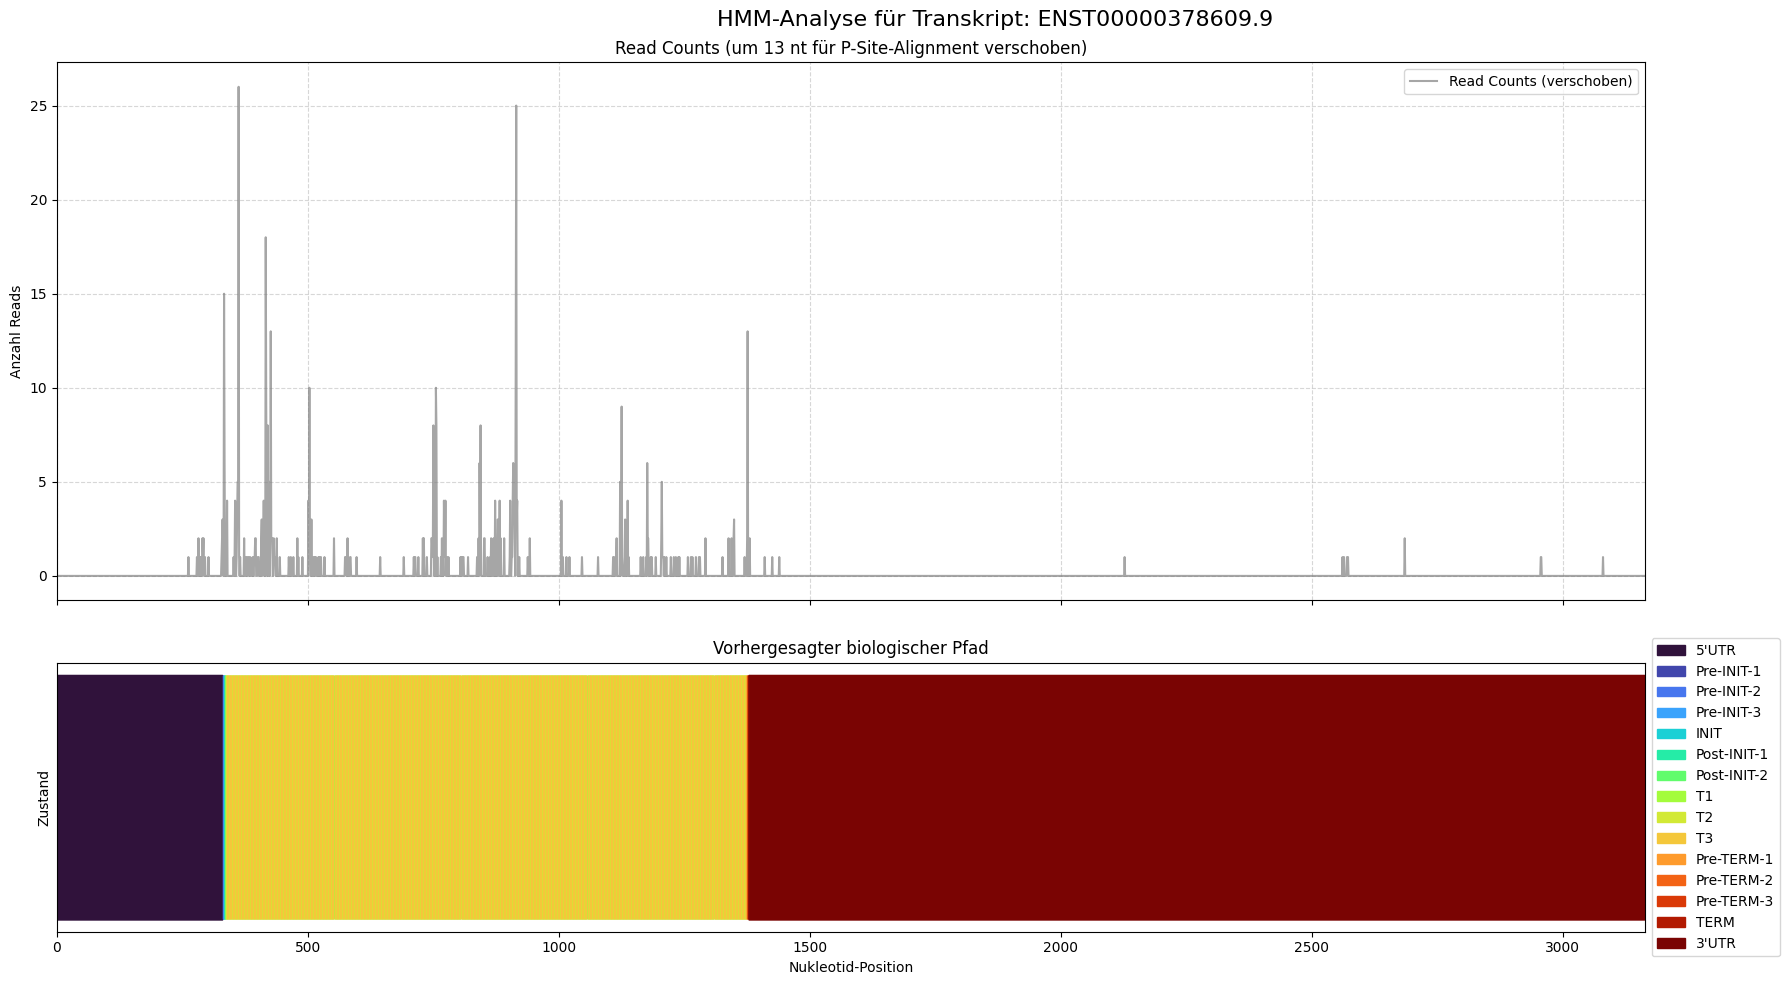

✅ Emissions-Vergleich gespeichert als 'hmm_emissions_comparison_15states_grouped.png'


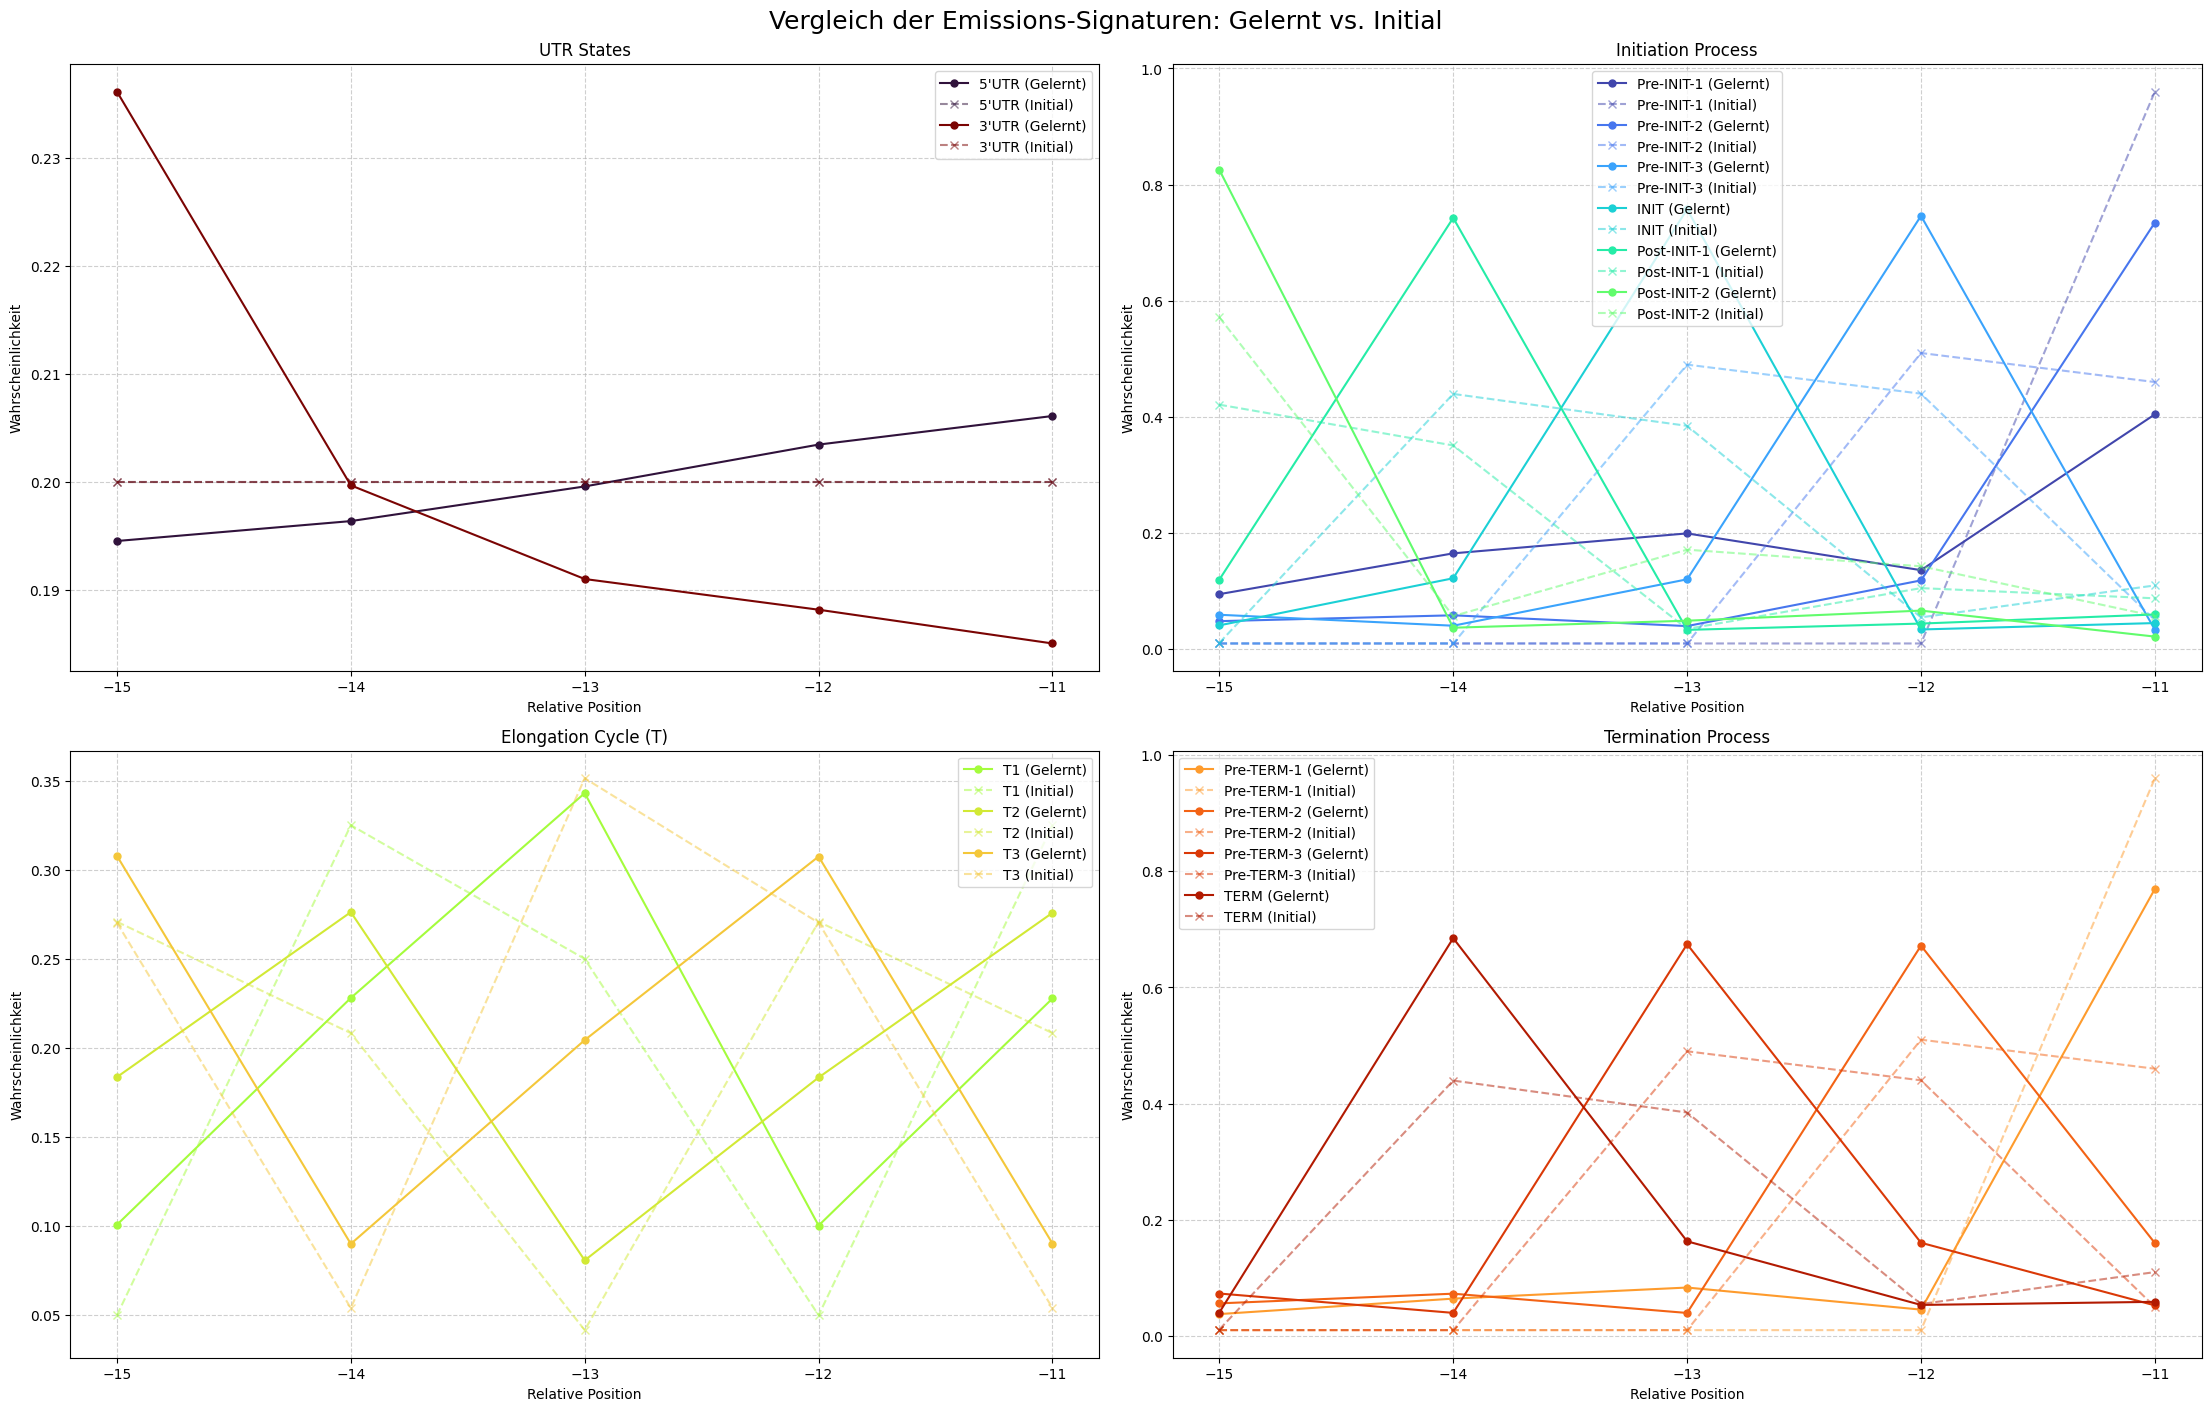

In [7]:
# --- 1. Inferenz für ein Beispiel-Transkript ---
print("\nFühre Inferenz für ein Beispiel-Transkript durch...")
example_tid = list(transcript_data.keys())[0]
example_read_counts = transcript_data[example_tid]
X_example = create_lagging_windows(example_read_counts, window_size, lag_offset).astype(np.int32)
logprob, state_sequence = model.decode(X_example, algorithm="viterbi")
print(f"Log-Wahrscheinlichkeit des dekodierten Pfades für {example_tid}: {logprob:.2f}")

# --- 2. Visualisierung der Ergebnisse ---

# Plot 1: Reads (verschoben) und dekodierter Pfad
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f"HMM-Analyse für Transkript: {example_tid}", fontsize=16)

# <<<<<<< ANPASSUNG: Reads für Plot um 13 nt verschieben >>>>>>>>>
p_site_shift = 13
# Create a new array that is p_site_shift longer than the original
shifted_counts = np.zeros(len(example_read_counts) + p_site_shift, dtype=np.float64)

# Place the original read counts starting from the shift position
shifted_counts[p_site_shift : p_site_shift + len(example_read_counts)] = example_read_counts

ax1.set_title(f"Read Counts (um {p_site_shift} nt für P-Site-Alignment verschoben)")
ax1.plot(shifted_counts, label=f"Read Counts (verschoben)", color='gray', alpha=0.7)
ax1.legend(loc='upper right')
ax1.set_ylabel("Anzahl Reads")
ax1.set_xlim(0, len(example_read_counts))
ax1.grid(True, linestyle='--', alpha=0.5)

ax2.set_title("Vorhergesagter biologischer Pfad")
for i, label in enumerate(state_labels):
    ax2.fill_between(np.arange(len(state_sequence)), 0, 1, where=(state_sequence == i), color=state_colors[i], label=label, step='post')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_ylabel("Zustand")
ax2.set_xlabel("Nukleotid-Position")
ax2.set_yticks([])
ax2.set_xlim(0, len(state_sequence))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("hmm_path_visualization_shifted.png")
print("✅ Pfad-Visualisierung (mit verschobenen Reads) gespeichert.")
plt.show()

# Plot 2: Vergleich der Emissions-Signaturen (JETZT GRUPPIERT)
fig_comparison, axs = plt.subplots(2, 2, figsize=(22, 14), constrained_layout=True)
fig_comparison.suptitle("Vergleich der Emissions-Signaturen: Gelernt vs. Initial", fontsize=18)
x_labels_rel = np.arange(n_features) - lag_offset

for ax, (group_name, members) in zip(axs.flat, plot_groups.items()):
    ax.set_title(group_name)
    for state_name in members:
        state_idx = state_map[state_name]
        # Gelernt
        ax.plot(x_labels_rel, model.emissionprob_[state_idx], 'o-', color=state_colors[state_idx], label=f'{state_name} (Gelernt)', markersize=5)
        # Initial
        ax.plot(x_labels_rel, initial_emissionprob_snapshot[state_idx], 'x--', color=state_colors[state_idx], alpha=0.5, label=f'{state_name} (Initial)', markersize=6)
    
    ax.set_xlabel("Relative Position")
    ax.set_ylabel("Wahrscheinlichkeit")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xticks(x_labels_rel)
    ax.legend()

plt.savefig("hmm_emissions_comparison_15states_grouped.png")
print("✅ Emissions-Vergleich gespeichert als 'hmm_emissions_comparison_15states_grouped.png'")
plt.show()

In [9]:
import numpy as np
from hmmlearn import hmm

# For this example, we will model the stages of a conversation,
# where each sentence is "generated" with an underlying topic, "cat" or "dog"
states = ["cat", "dog"]
id2topic = dict(zip(range(len(states)), states))
# we are more likely to talk about cats first
start_probs = np.array([0.6, 0.4])

# For each topic, the probability of saying certain words can be modeled by
# a distribution over vocabulary associated with the categories

vocabulary = ["tail", "fetch", "mouse", "food"]
# if the topic is "cat", we are more likely to talk about "mouse"
# if the topic is "dog", we are more likely to talk about "fetch"
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Also assume it's more likely to stay in a state than transition to the other
trans_mat = np.array([[0.8, 0.2], [0.2, 0.8]])


# Pretend that every sentence we speak only has a total of 5 words,
# i.e. we independently utter a word from the vocabulary 5 times per sentence
# we observe the following bag of words (BoW) for 8 sentences:
observations = [["tail", "mouse", "mouse", "food", "mouse"],
        ["food", "mouse", "mouse", "food", "mouse"],
        ["tail", "mouse", "mouse", "tail", "mouse"],
        ["food", "mouse", "food", "food", "tail"],
        ["tail", "fetch", "mouse", "food", "tail"],
        ["tail", "fetch", "fetch", "food", "fetch"],
        ["fetch", "fetch", "fetch", "food", "tail"],
        ["food", "mouse", "food", "food", "tail"],
        ["tail", "mouse", "mouse", "tail", "mouse"],
        ["fetch", "fetch", "fetch", "fetch", "fetch"]]

# Convert "sentences" to numbers:
vocab2id = dict(zip(vocabulary, range(len(vocabulary))))
def sentence2counts(sentence):
    ans = []
    for word, idx in vocab2id.items():
        count = sentence.count(word)
        ans.append(count)
    return ans

X = []
for sentence in observations:
    row = sentence2counts(sentence)
    X.append(row)

data = np.array(X, dtype=int)

In [10]:
row

[0, 5, 0, 0]